In [147]:
import numpy as np
import pandas as pd
import json
import re

import collections

import matplotlib.pyplot as plt

# Parsing Helpers

In [148]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    for s in markets:
        md_preprocess(markets[s])
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask_price_1 - md.bid_price_1
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    md['quote_wgt_px'] = (md.bid_volume_1*md.bid_price_1 + md.ask_volume_1*md.ask_price_1)/(md.bid_volume_1+md.ask_volume_1)
    for t in [1, 2, 3, 4, 5, 10, 30, 100, 200]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)

    md['quote_imbalance'] = (md.bid_volume_1)/(md.bid_volume_1 + md.ask_volume_1)
    
    return

In [156]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    # order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            # extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    own_trades = pd.DataFrame(own_trades)
    # order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
                
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        for t in state['order_depths'][sym]:
            pass

        
def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """
    
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df

def load_data_from_log(file):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades = process_trading_state_jsons(trading_states)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    dfs = {}
    dfs['orders'] = create_sent_orders_df(sent_orders)
    dfs['positions'] = positions
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    return dfs

# Data Loading

In [157]:
log_file = "logs/e0a30df3-402b-48e0-8823-b08296a7f817.log"
dfs = load_data_from_log(log_file)
results_file = "results/tutorial_results1_v1.csv"
markets = load_market_data(results_file)

Symbols: ['BANANAS', 'PEARLS']


In [158]:
dfs['market_trades'].head()

,price,quantity,symbol,timestamp
0,10002.0,1,PEARLS,100
1,4952.0,9,BANANAS,400
2,4952.0,1,BANANAS,500
3,10004.0,1,PEARLS,500
4,4945.0,1,BANANAS,1400


In [159]:
dfs['own_trades'].head()

,price,quantity,symbol,timestamp,side
0,9998.0,2,PEARLS,300,1
1,9998.0,1,PEARLS,300,1
2,10002.0,1,PEARLS,500,-1
3,10002.0,1,PEARLS,1500,-1
4,10002.0,10,PEARLS,2900,-1


In [48]:
def md_trade_quote_join():
    pass

# Plotting

In [126]:
def plot_bbo(md, sym):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", "bid_price_1", data=md, color="red")
    ax.plot("timestamp", "ask_price_1", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

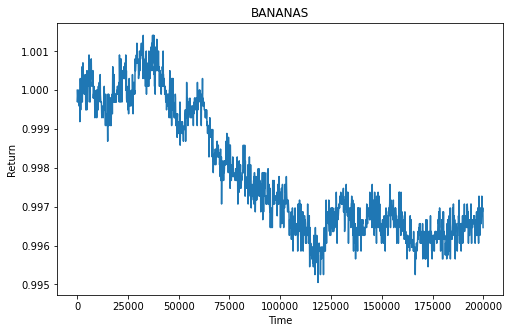

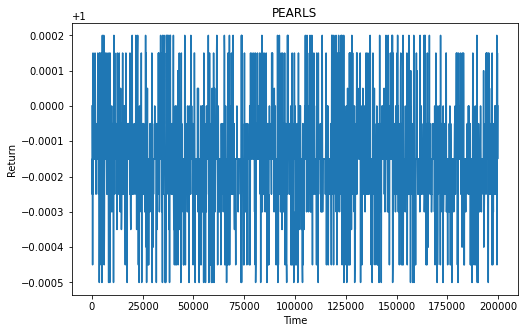

In [129]:
for s in symbols:
    plot_price(markets[s], s, "return")    
    # plot_price(markets[s], s, "mid_px_mavg10")